In [250]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics




snp_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
nasdaq_url = "https://en.wikipedia.org/wiki/Nasdaq-100"
ta_url = "https://en.wikipedia.org/wiki/TA-125_Index"
# api_key = "b87d58d0d348ad7cf92e6293b53d7720"

In [252]:
def load_soup_object(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')
    return soup


In [3]:
def get_snp_stocks_symbols(url):
    soup = load_soup_object(url)
    stocks = soup.find_all('tbody')[0]
    stocks_names = list()
    stocks_symbols = list()
    for row in stocks('tr'):
        cels = row("a")
        stocks_symbols.append(cels[0].get_text().strip())
        stocks_names.append(cels[1].get_text().strip())
    stocks_symbols.remove('Symbol')
    stocks_names.remove('SEC filings')
    df = pd.DataFrame({"stock_name":stocks_names,"stock_symbol":stocks_symbols})
    return df
    
    
    

In [4]:
def get_nasdaq_stocks_symbols(url):
    soup = load_soup_object(url)
    stocks = soup.find_all('tbody')[3]
    stocks_names = list()
    stocks_symbols = list()
    for row in stocks('tr'):
        names = row("a")
        stocks_names.append(names[0].get_text().strip())
        stocks_symbols.append(row.get_text().splitlines()[2])
    
    stocks_names.remove("GICS")
    stocks_symbols.remove("Ticker")
    df = pd.DataFrame({"stock_name":stocks_names,"stock_symbol":stocks_symbols})
    return df

In [5]:
def get_ta_stocks_symbols(url):
    soup = load_soup_object(url)
    stocks = soup.find_all('tbody')[1]
    stocks_names = list()
    stocks_symbols = list()
    for row in stocks('tr'):
        name = row("a")
        if(len(name)>0):
            stocks_names.append(name[0].text)
        else:
            stocks_names.append(row.get_text().splitlines()[1])
            
        stocks_symbols.append(row.get_text().splitlines()[3])
        
    stocks_names.remove("Name")
    stocks_symbols.remove("Symbol")
    df = pd.DataFrame({"stock_name":stocks_names,"stock_symbol":stocks_symbols})
    return df

In [6]:
def concat_tabels(snp_df,nasdaq_df,ta_df):
    combined_df = pd.concat([snp_df, nasdaq_df,ta_df],ignore_index = True, axis=0)
    return combined_df

In [7]:
def remove_duplicates(df):
    df = df.drop_duplicates()
    return df


In [8]:
# def get_stocks_prices(stocks):
#     keys = stocks['stock_symbol'].tolist()
#     data_dict = {}
#     index = 0
#     dates_full = []
#     for stock in stocks.iterrows():
#         symbol = stock[1].at['stock_symbol']
#         price_list = []
#         dates = []
#         data = yf.Ticker(symbol)
#         prices = data.history(start="2020-01-01", end="2022-01-01",interval ="1mo")
#         for i in range(len(prices)):
#             price_list.append(prices['Close'][i])
#             dates.append(str(prices['Close'].keys()[i].date()))
#         if(len(dates) > len(dates_full)):
#             dates_full = dates
#         data_dict[keys[index]] = price_list
#         index+=1 
#     df = pd.DataFrame.from_dict(data_dict, orient='index',
#                        columns=dates_full)
#     return df
        
        

In [9]:
def get_stocks_data(stocks,start_date,end_date,intervals):
    keys = stocks['stock_symbol'].tolist()
    data = yf.download(keys,start=start_date, end=end_date,interval =intervals)
    df = pd.DataFrame(dict(data['Close'].items()))
    return df

In [10]:
def remove_missing_rows(df,x):
    if x==0:
        df2=df.dropna(axis=0, how="any", subset=None, inplace=False)
    else:    
        df2=df.dropna(axis=0, how="any", thresh=x, subset=None, inplace=False)
    return df2


def remove_missing_cols(df,x):
    if x==0:
        df2=df.dropna(axis=1, how="any", subset=None, inplace=False)
    else:    
        df2=df.dropna(axis=1, how="any", thresh=x, subset=None, inplace=False)
    return df2

In [11]:
def get_experts_recomendations(page_url):
    url = "https://www.wallstreetzen.com/stock-screener/stock-forecast" + page_url
    soup = load_soup_object(url)
    data = soup.find('tbody', attrs = {"class" : "MuiTableBody-root-504"})
    tickers = []
    predictions = []
    for row in data('tr'):
        tickers.append(row.find('a').text)
        predictions.append(row.find_all('td')[7].text)
    df = pd.DataFrame(predictions,index = tickers, columns = ['prediction'])
    return df




In [12]:
def create_recomendations_data(start,prediction_df):
    symbols = prediction_df.index.values.tolist()
    data =  yf.download(symbols[start:start + 100],'2009-01-13','2022-01-24','1mo')
    df = pd.DataFrame(dict(data['Close'].items()))
    return df

In [13]:
def create_recomendations_df():
    df = get_experts_recomendations("")
    for i in range(2,10):
        page_url = "?t=6&p="+str(i)+"&s=mc&sd=desc"
        df = pd.concat([df,get_experts_recomendations(page_url)],ignore_index = False, axis=0)
    return df

In [19]:
def get_recomendation_data(recomendations_df):
    
    recomendations_data  = pd.DataFrame()
    for start in range(0,801,100):
        recomendations_data = pd.concat([recomendations_data,create_recomendations_data(start,recomendations_df)],ignore_index = False, axis=1)
    return recomendations_data


    

In [131]:
def get_increase_decrease_data(symbol):
    snp_stock = yf.download([symbol],start = "1984-01-01",end = "2021-01-01", interval = "1mo")
    df = pd.DataFrame(snp_stock)
    return df

In [21]:
snp_symbols_df = get_snp_stocks_symbols(snp_url)
nasdaq_symbols_df = get_nasdaq_stocks_symbols(nasdaq_url)
ta_symbols_df = get_ta_stocks_symbols(ta_url)
stocks_symbols_df = remove_duplicates(concat_tabels(snp_symbols_df,nasdaq_symbols_df,ta_symbols_df))
stocks_symbols_df

,stock_name,stock_symbol
0,3M,MMM
1,A. O. Smith,AOS
2,Abbott,ABT
3,AbbVie,ABBV
4,Abiomed,ABMD
...,...,...
727,Levinstein Properties Ltd.,LVPR
728,Hadera Paper Ltd.,HAP
729,FMS Enterprises Migun Ltd.,FBRT
730,Doral Group Renewable Energy Resources Ltd.,DORL


In [22]:
stocks_data_df = get_stocks_data(stocks_symbols_df,'2007-01-01','2022-01-01','1mo')
stocks_data_df

[*********************100%***********************]  653 of 653 completed

85 Failed downloads:
- : No data found for this date range, symbol may be delisted
- ILX: No data found for this date range, symbol may be delisted
- ASHG: No data found for this date range, symbol may be delisted
- ILCO: No data found for this date range, symbol may be delisted
- AZRG: No data found, symbol may be delisted
- PHOE: No data found, symbol may be delisted
- ILDC: No data found, symbol may be delisted
- MMHD: No data found for this date range, symbol may be delisted
- FRSM: No data found, symbol may be delisted
- MLTM: No data found, symbol may be delisted
- SMT: No data found for this date range, symbol may be delisted
- YHNF: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- AFPR: No data found, symbol may be delisted
- ENOG: No data found, symbol may be delisted
- IES: None
- DORL: None
- CRSO: No data found, symbol may be delisted
- KRUR: No data found, symbol

,,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABNB,ABT,...,XRAY,XYL,YHNF,YUM,ZBH,ZBRA,ZION,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,NaN,22.889843,55.98,37.950001,3.061786,NaN,26.190001,14.71,NaN,25.429399,...,30.84,NaN,NaN,21.570812,84.220001,34.669998,84.82,NaN,NaN,NaN
2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
stocks_data_df = remove_missing_rows(stocks_data_df,1)
stocks_data_df = remove_missing_cols(stocks_data_df,0)
stocks_data_df

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WY,WYNN,XEL,XLNX,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,22.889843,55.980000,37.950001,3.061786,26.190001,14.710000,25.429399,37.750000,38.869999,32.750000,...,75.000000,111.739998,23.330000,24.299999,74.099998,30.840000,21.570812,84.220001,34.669998,84.820000
2007-02-01,22.711016,52.290001,37.650002,3.021786,26.299999,13.980000,26.206676,35.779999,39.250000,36.310001,...,85.910004,98.019997,23.629999,25.620001,71.680000,31.540001,20.826742,84.269997,39.610001,85.379997
2007-03-01,24.098713,45.480000,38.549999,3.318214,26.375000,13.660000,26.772840,38.540001,41.700001,34.490002,...,74.739998,94.860001,24.690001,25.730000,75.449997,32.750000,20.762041,85.410004,38.610001,84.519997
2007-04-01,24.585121,36.939999,41.200001,3.564286,24.995001,12.820000,27.166277,39.099998,41.560001,38.619999,...,79.220001,102.209999,24.090000,29.480000,79.379997,33.410000,22.235802,90.480003,39.790001,81.800003
2007-05-01,27.303289,35.650002,41.419998,4.328214,25.610001,11.160000,27.036730,40.939999,44.060001,36.209999,...,81.959999,96.500000,22.950001,28.480000,83.169998,36.150002,24.342199,88.059998,40.110001,80.459999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,175.470001,19.940001,202.850006,151.830002,122.209999,363.959991,126.370003,336.559998,663.700012,162.949997,...,36.000000,101.690002,68.750000,155.589996,54.520000,61.700001,131.029999,150.449997,587.169983,57.900002
2021-09-01,157.529999,20.520000,208.889999,141.500000,119.449997,325.519989,118.129997,319.920013,575.719971,167.479996,...,35.570000,84.750000,62.500000,150.990005,58.820000,58.049999,122.309998,146.360001,515.419983,61.889999
2021-10-01,157.490005,19.200001,225.520004,149.800003,122.019997,332.040009,128.889999,358.790009,650.359985,173.490005,...,35.720001,89.800003,64.589996,180.000000,64.470001,57.209999,124.940002,143.119995,533.950012,62.990002


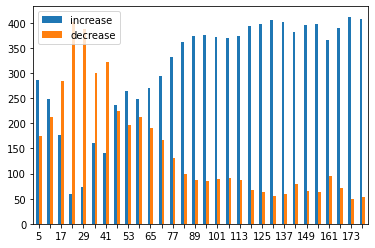

In [256]:
def imaging_change_in_prices(df):
    increase_dict = dict()
    df = df.transpose()
    for row in df.iterrows():
        for i in range(5,len(row[1]),6):
            increase_dict.setdefault(i, []).append(1 if row[1][i] > row[1][0] else 0)

    prepare_data_for_graph(df,increase_dict)
    
def prepare_data_for_graph(df,increase_dict):
    amount_increase_list = []
    amount_decrease_list = []
    months_list = []
    num_of_increase = 0
    num_of_decrease = 0
    for column in increase_dict:
        for val in increase_dict[column]:
            if val == 1:
                num_of_increase+=1 
            else:
                num_of_decrease +=1
        
        amount_increase_list.append(num_of_increase)
        amount_decrease_list.append(num_of_decrease)
        months_list.append(column)
        num_of_increase = 0
        num_of_decrease = 0
        
        d = {'increase' : amount_increase_list ,'decrease':amount_decrease_list }
    graph_df = pd.DataFrame(d,index = months_list)
    show_graph(graph_df)
    
def show_graph(graph_df):
    ax = graph_df.plot.bar(rot=0)
    ax.set_xticklabels([t if not i%2 else "" for i,t in enumerate(ax.get_xticklabels())])

        
imaging_change_in_prices(stocks_data_df)    

In [257]:
def predict_stock_price(symbol,stocks_prices_df):
    stock_prices = stocks_prices_df[symbol]
    stock_prices = pd.DataFrame(stock_prices)
    stock_prices
    stock_prices['days_from_start'] = (stock_prices.index - stock_prices.index[0]).days;
    print(stock_prices)
    X_train, X_test, y_train, y_test = train_test_split(stock_prices.days_from_start,stock_prices[symbol])
    plt.scatter(X_train,y_train,label='Training Data' , color= 'r', alpha = .7)
    plt.scatter(X_test,y_test,label='Testing Data' , color= 'g', alpha = .7)
    plt.legend()
    plt.title("train test split")
    plt.show()
    LR = LinearRegression()
    LR.fit(X_train.values.reshape(-1,1),y_train)

    prediction = LR.predict(X_test.values.reshape(-1,1))
    plt.plot(X_test,prediction,label = 'Linear Regression', color = 'b', alpha = .7)
    plt.scatter(X_test,y_test,label = 'Actual test data',color= 'g', alpha = .7)
    plt.legend()
    plt.show()

                  AAPL  days_from_start
Date                                   
2007-01-01    3.061786                0
2007-02-01    3.021786               31
2007-03-01    3.318214               59
2007-04-01    3.564286               90
2007-05-01    4.328214              120
...                ...              ...
2021-08-01  151.830002             5326
2021-09-01  141.500000             5357
2021-10-01  149.800003             5387
2021-11-01  165.300003             5418
2021-12-01  177.570007             5448

[180 rows x 2 columns]


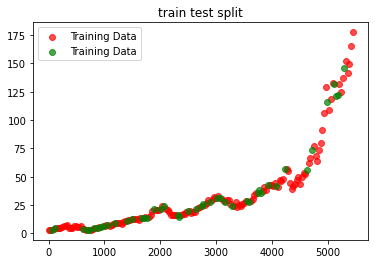

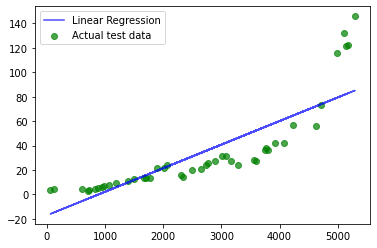

In [258]:
predict_stock_price('AAPL',stocks_data_df)

In [28]:
recomendations_df = create_recomendations_df()

In [29]:
recomendation_data = get_recomendation_data(recomendations_df)


[*********************100%***********************]  100 of 100 completed

2 Failed downloads:
- RDS.A: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed

1 Failed download:
- BF.B: None
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed


In [30]:

recomendation_data= remove_missing_cols(recomendation_data,3280)
recomendation_data = remove_missing_rows(recomendation_data,0)


In [31]:
def remove_missing_recomendation(prediction_df,df2):
    for row in prediction_df.iterrows():
        if row[0] not in df2.columns:
            prediction_df = prediction_df.drop(row[0])  
    return prediction_df


In [39]:
def get_avg_monthly_change(recomendation_data):
    print(recomendation_data)
    monthly_change = 0.0
    change_rates = []
    for row in recomendation_data.iterrows():
        for i in range(1,len(row)):
            diff = row[1][i] - row[1][i-1]
            val = row[1][i-1]
            monthly_change += (diff * 100) / (val)
        monthly_change = monthly_change/len(row)
        change_rates.append(monthly_change)
    return change_rates

In [40]:
get_avg_monthly_change(recomendation_data)

                  AAPL         ABT         ACN        ADBE        AMAT  \
Date                                                                     
2009-01-12    3.166429   24.018787   33.029999   23.760000   10.000000   
2009-01-13    3.132500   24.018787   34.070000   22.100000   10.190000   
2009-01-14    3.047500   23.735706   32.439999   21.110001    9.730000   
2009-01-15    2.977857   23.615755   32.650002   20.830000    9.700000   
2009-01-16    2.940357   23.951616   32.680000   21.059999   10.180000   
...                ...         ...         ...         ...         ...   
2022-01-14  173.070007  128.160004  353.359985  520.599976  167.000000   
2022-01-18  169.800003  126.570000  348.279999  513.340027  152.360001   
2022-01-19  166.229996  126.050003  343.739990  516.580017  143.070007   
2022-01-20  164.509995  124.709999  342.690002  510.850006  139.149994   
2022-01-21  162.410004  125.830002  335.630005  499.910004  135.059998   

                   AMD        AMGN   

[329.27247159581617,
 498.0167289487682,
 588.4375219214816,
 640.7413976412697,
 677.661659288417,
 711.4475226509471,
 730.0192261633329,
 717.9960386124753,
 710.4640184612709,
 710.2572382970342,
 707.8052645448008,
 695.8105827428119,
 698.1203500283675,
 712.2428280396592,
 714.0274634076162,
 718.6571996782976,
 710.7810027313096,
 699.0493560000103,
 684.4905188286834,
 667.3888890046325,
 666.7595025728197,
 669.8164960748211,
 664.7172970111875,
 654.5277927599712,
 660.4847224264984,
 666.0347134139874,
 686.6125529579849,
 691.2561570480215,
 708.1623103067215,
 711.5044977197772,
 700.8556851865021,
 681.3629015093459,
 646.7359125515546,
 632.6778503941665,
 614.626977015849,
 604.9251371393322,
 600.5714212857954,
 619.5347955097617,
 636.8067416948268,
 624.4612085105874,
 584.5373494267412,
 567.4969136990546,
 561.8010648449579,
 567.746088625722,
 565.0823208165257,
 554.3077644056596,
 541.332665226111,
 535.0040911058552,
 521.7289371966137,
 503.89840702358765,
 4

In [34]:
recomendations_df_copy = recomendations_df.copy()
recomendations_df_copy = remove_missing_recomendation(recomendations_df_copy,recomendation_data)
recomendations_df_copy



,prediction
AAPL,Strong Buy
MSFT,Strong Buy
GOOGL,Strong Buy
AMZN,Strong Buy
TSM,Buy
...,...
ARW,Hold
GGB,Buy
WF,Hold
CLF,Buy


In [50]:
recomendation_data = recomendation_data.transpose()

In [52]:

change_rates = get_avg_monthly_change(recomendation_data)
change_rates
train_dataset = pd.DataFrame(zip(change_rates,recomendation_data.iloc[:,-1:].values.flatten(),recomendations_df_copy['prediction']),
                             index = recomendations_df_copy.index, columns = ["change", 'last_price', 'label'])
train_dataset

Date  2009-01-12  2009-01-13  2009-01-14  2009-01-15  2009-01-16  2009-01-20  \
AAPL    3.166429    3.132500    3.047500    2.977857    2.940357    2.792857   
ABT    24.018787   24.018787   23.735706   23.615755   23.951616   23.606159   
ACN    33.029999   34.070000   32.439999   32.650002   32.680000   31.879999   
ADBE   23.760000   22.100000   21.110001   20.830000   21.059999   19.389999   
AMAT   10.000000   10.190000    9.730000    9.700000   10.180000    9.400000   
...          ...         ...         ...         ...         ...         ...   
UTHR   31.190001   31.459999   30.450001   31.594999   31.370001   31.000000   
WF     19.702026   21.454111   21.036949   19.797379   20.202621   17.878428   
WYNN   41.000000   39.230000   36.279999   36.130001   36.939999   32.970001   
Y     271.417114  283.846344  266.677216  267.242615  270.804596  246.417297   
ZION   20.820000   21.910000   20.990000   18.240000   16.490000   13.330000   

Date  2009-01-21  2009-01-22  2009-01-2

,change,last_price,label
AAPL,-0.535763,162.410004,Strong Buy
MSFT,-0.267881,125.830002,Strong Buy
GOOGL,1.440387,335.630005,Strong Buy
AMZN,-2.773072,499.910004,Strong Buy
TSM,-0.436538,135.059998,Buy
...,...,...,...
ARW,0.631108,200.059998,Hold
GGB,4.762012,36.700001,Buy
WF,0.222469,85.650002,Hold
CLF,2.400926,652.400024,Buy


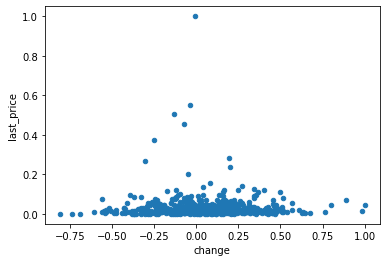

,change,last_price,label
AAPL,-0.075878,0.031505,Strong Buy
MSFT,-0.037939,0.024409,Strong Buy
GOOGL,0.203997,0.065108,Strong Buy
AMZN,-0.392740,0.096976,Strong Buy
TSM,-0.061825,0.026200,Buy
...,...,...,...
ARW,0.089382,0.038809,Hold
GGB,0.674426,0.007119,Buy
WF,0.031507,0.016615,Hold
CLF,0.340034,0.126557,Buy


In [53]:
df_max_scaled = train_dataset.copy()
df_max_scaled['last_price'] = df_max_scaled['last_price'] /df_max_scaled['last_price'].abs().max()
df_max_scaled['change'] = df_max_scaled['change'] /df_max_scaled['change'].abs().max()
df_max_scaled.plot(kind = 'scatter' , x = 'change', y = 'last_price')
plt.show()
df_max_scaled

In [54]:
def train_model(k):
    #creating labelEncoder
    le = preprocessing.LabelEncoder()
    # Converting string labels into numbers.
    label_encoded=le.fit_transform(df_max_scaled['label'])\

    X = df_max_scaled.drop('label',axis = 1)
    y = df_max_scaled['label']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    #Train the model using the training sets
    knn.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = knn.predict(X_test)
    
    evaluate_optimal_k(X_train,y_train,X_test,y_test)
    
    
    return metrics.accuracy_score(y_test, y_pred)

In [55]:
def evaluate_optimal_k(X_train,y_train,X_test,y_test):
    error = []

    # Calculating error for K values between 1 and 40
    for i in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test))

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')

0.48872180451127817


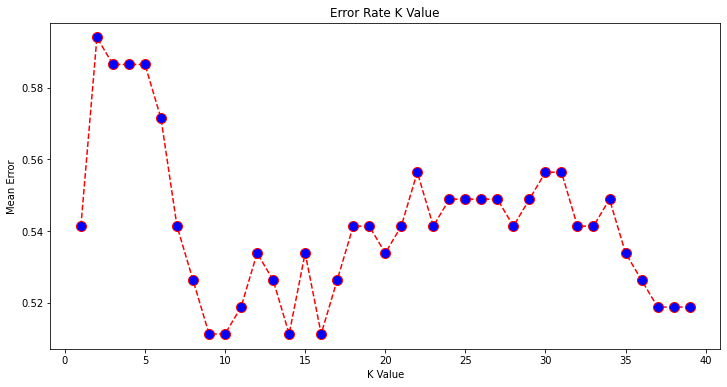

In [62]:
print(train_model(10))


In [132]:
snp_price_data = get_increase_decrease_data("^GSPC")
snp_price_data



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-01,167.199997,180.270004,163.360001,179.630005,179.630005,2673710000
1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2194620000
1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2153090000
1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1981880000
1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2350340000
...,...,...,...,...,...,...
2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000
2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000
2020-10-01,3385.870117,3549.850098,3233.939941,3269.959961,3269.959961,89737600000


In [133]:
def get_increase_list(df):
    next_month_close = []
    for i in range(1,len(df)):
        next_month_close.append(0 if df['Close'][i] < df['Close'][i-1] else 1 )
    df.drop(index=df.index[0], 
            axis=0, 
            inplace=True)
    return next_month_close



In [134]:
next_month_close =get_increase_list(snp_price_data) 
snp_price_data.insert(6,"increased", next_month_close, True)
snp_price_data


,Open,High,Low,Close,Adj Close,Volume,increased
Date,,,,,,,
1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2194620000,1
1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2153090000,0
1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1981880000,0
1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2350340000,1
1985-06-01,189.550003,191.850006,185.029999,191.850006,191.850006,2117000000,1
...,...,...,...,...,...,...,...
2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000,1
2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000,0
2020-10-01,3385.870117,3549.850098,3233.939941,3269.959961,3269.959961,89737600000,0


In [272]:
snp_price_data =pd.get_dummies(snp_price_data)
snp_price_data




,Open,High,Low,Close,Adj Close,Volume,increased
Date,,,,,,,
1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2194620000,1
1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2153090000,0
1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1981880000,0
1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2350340000,1
1985-06-01,189.550003,191.850006,185.029999,191.850006,191.850006,2117000000,1
...,...,...,...,...,...,...,...
2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000,1
2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000,0
2020-10-01,3385.870117,3549.850098,3233.939941,3269.959961,3269.959961,89737600000,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(snp_price_data.drop('increased', axis =1), snp_price_data['increased'])


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


In [271]:
log_reg.score(X_test,y_test)

0.6944444444444444

In [249]:
snp_price_data

,Open,High,Low,Close,Adj Close,Volume,increased
Date,,,,,,,
1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2194620000,1
1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2153090000,0
1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1981880000,0
1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2350340000,1
1985-06-01,189.550003,191.850006,185.029999,191.850006,191.850006,2117000000,1
...,...,...,...,...,...,...,...
2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000,1
2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000,0
2020-10-01,3385.870117,3549.850098,3233.939941,3269.959961,3269.959961,89737600000,0
